 Ce document présente un premier modèle de détection de raquette en se basant

sur l'architecture YOLOv5. 
**L'architecture YOLOv5 peut être schématisée de la manière suivante**  :
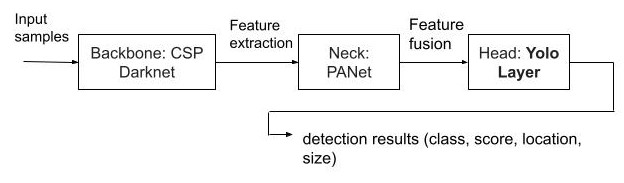


 **Elle se compose de trois parties : (1) Backbone : CSPDarknet, (2) Neck : PANet et (3) Head : Yolo Layer**. Les données sont d'abord entrées dans CSPDarknet pour l'extraction de caractéristiques, puis transmises à PANet pour la fusion de caractéristiques. Enfin, Yolo Layer génère des résultats de détection (classe, score, emplacement, taille) (comme le montre la figure ci-dessus).
Notre démarche de détection peut être résumée en 3 étapes essentielles :
 

*  Choix d'une vidéo support de la détection  et la découper en plusieurs frames.
*   Annotation des images, décompostion des images annotées en data d'entraînement, data de validation et data de test ( avec le moins de biais possible).
*  Entraînement du modèle, mesure des performances du modèle sur une vidéo et identification de ses limites en vue de l'améliorer. 



In [ ]:
# Vidéo utilisée comme support de détection
import IPython
url='https://www.youtube.com/watch?v=UAXvXMUe6uM&ab_channel=LBWTableTennis'
def windows_open(url):
    IPython.display.display(IPython.display.Javascript('window.open("{url}");'.format(url=url)))



In [ ]:
windows_open(url)

<IPython.core.display.Javascript object>

**La 1 ère étape qu'on a faite est qu'on a importé une vidéo d'un match de tennis de table( voir la vidéo en éxécutant le code ci-dessus)**.
**C'est le match de Tristan Flore contre Timo Boll**.
 **Ensuite, Roboflow réalise son découpage en plusieurs frames (en moyenne de 2 frames/s), ce qui nous fait environ 450 images**.
**On a alors essayé d'annoter ces images par Roboflow**.
**Lien vers le site d'annotation roboflow et notre projet nommé raquette avec les annotations faites et la base d'images utilisées** :https://universe.roboflow.com/ecole-centrale-de-lyon/raquette






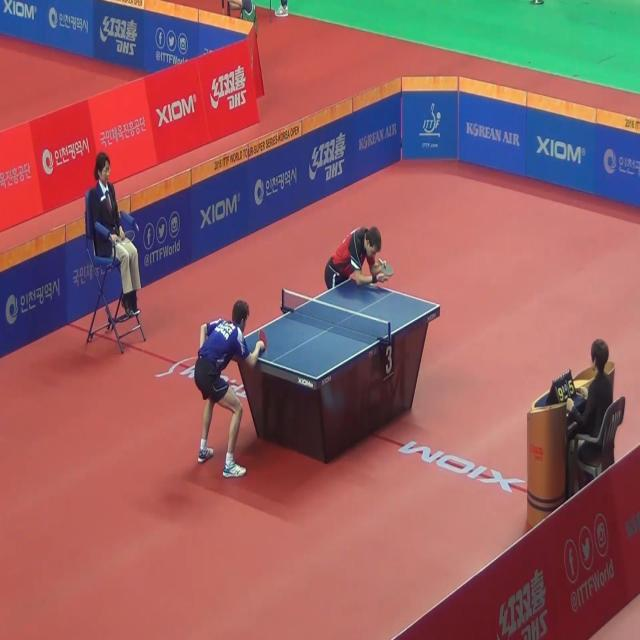

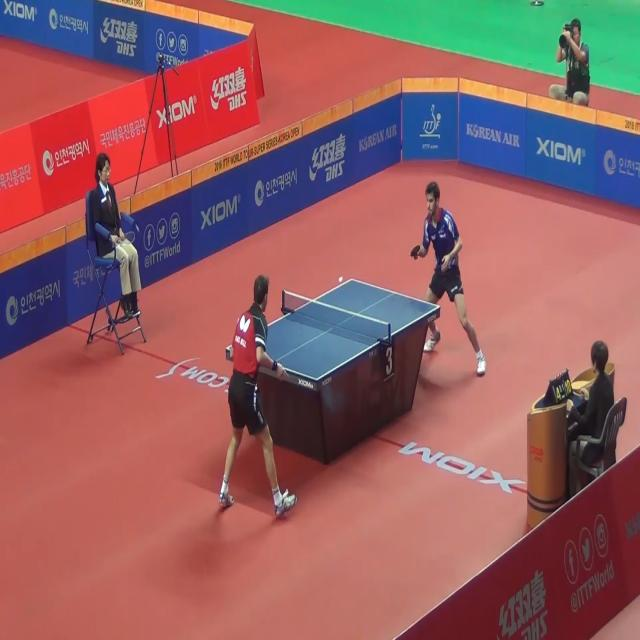

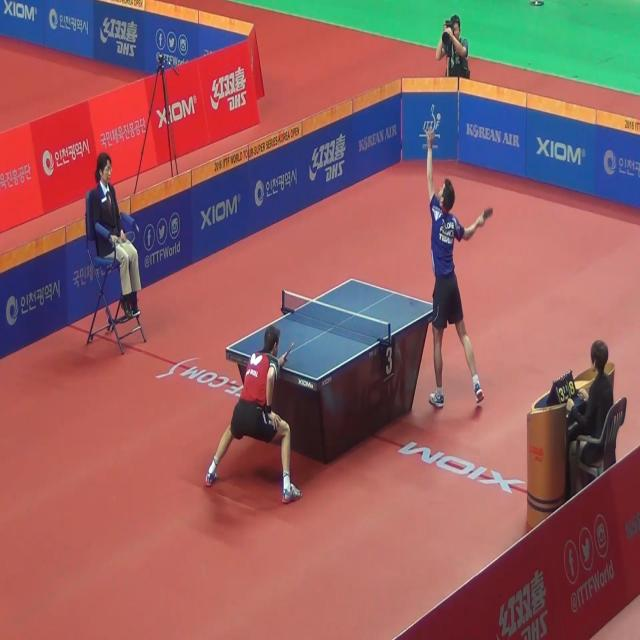

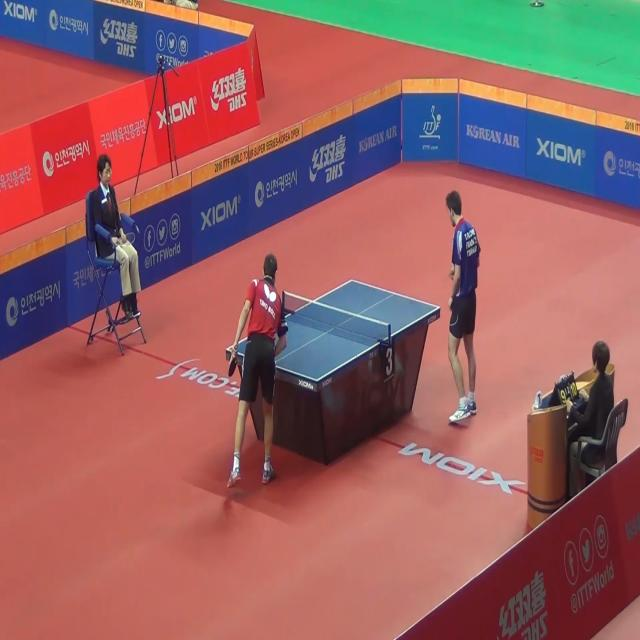

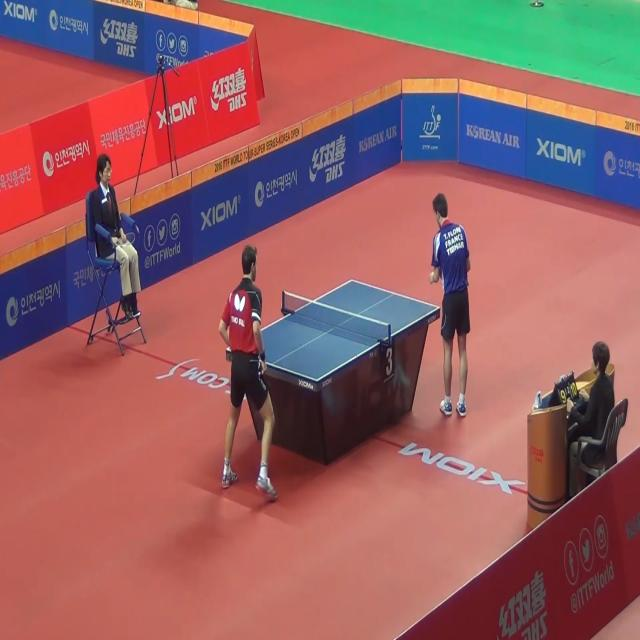

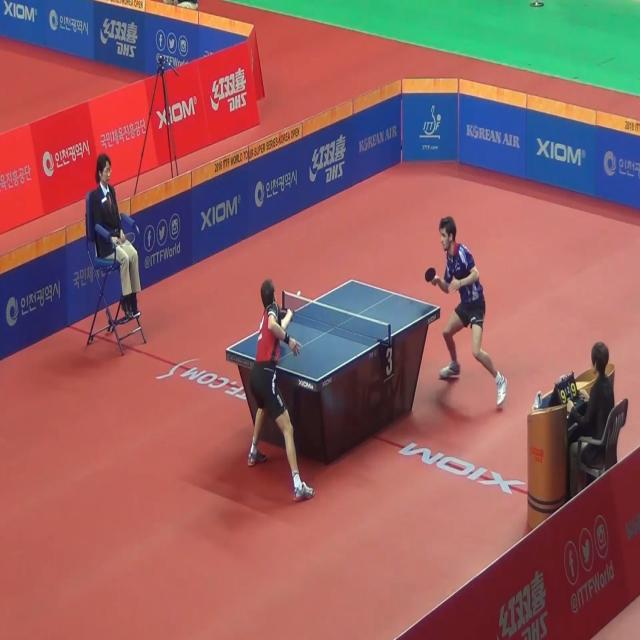

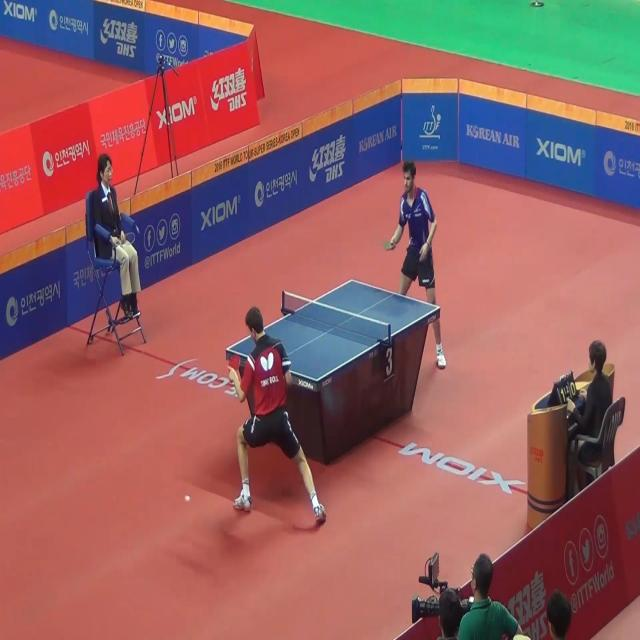

In [ ]:
       

from IPython.display import Image
import os
path1 = 'Test/'       

listing = os.listdir(path1)
for file in listing[:7]:
    #read the image
    im = Image(path1+ file,width=500, height=500)    
    #show image
    display(im)     



**Ensuite, on a essayé d'annoter les images avec RobotFlow.Ces annotations étaient plus au moins difficiles selon la position, l'orientation et la visibilité ou non de la raquette.(voir quelques images annotées en exécutant le code ci-dessous).**

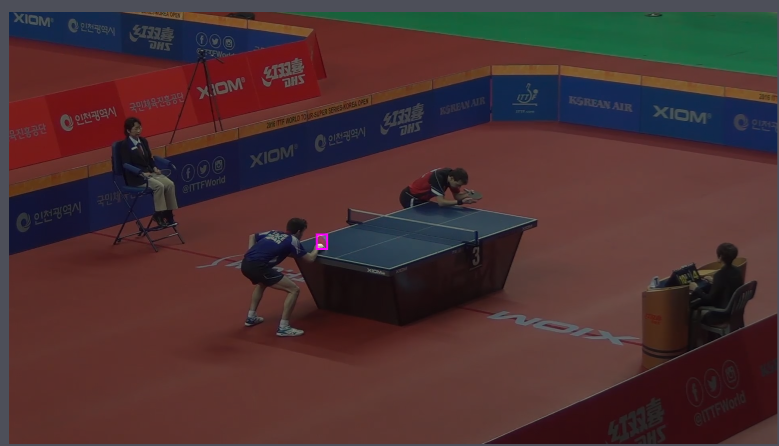

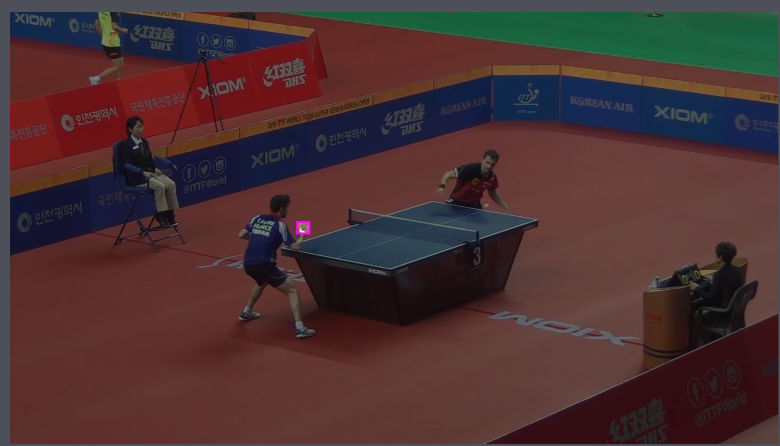

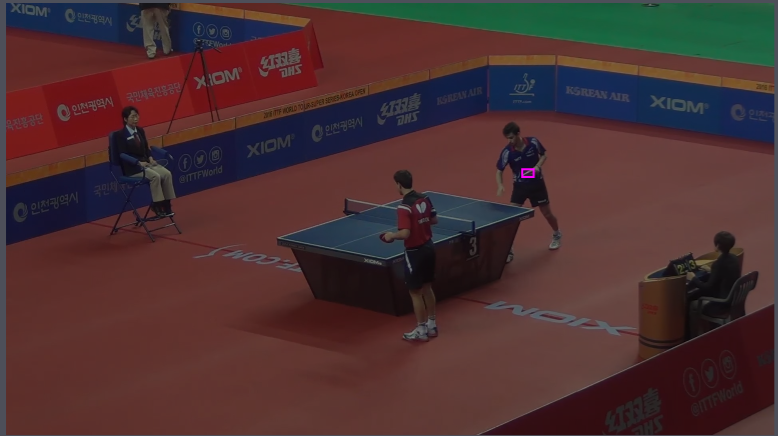

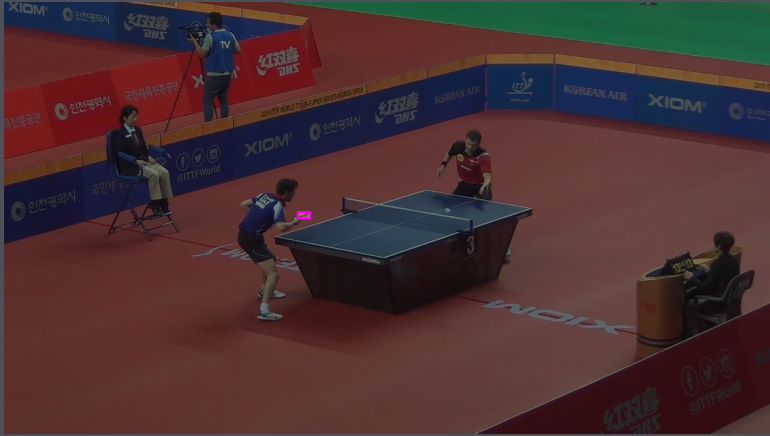

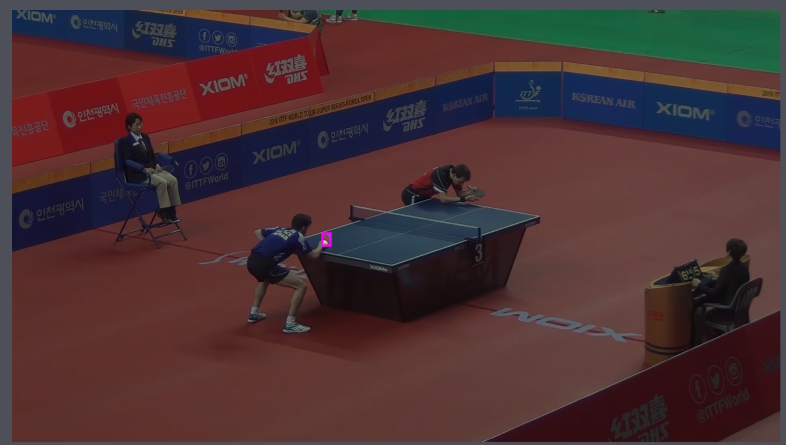

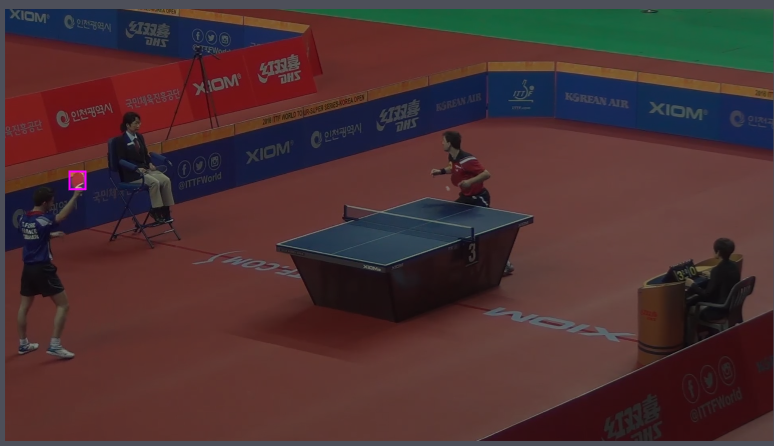

In [ ]:
from IPython.display import Image
import os
path1 = 'Images_annotées/'       

listing = os.listdir(path1)
for file in listing[:7]:
    #read the image
    im = Image(path1+ file,width=500, height=500)    
    #show image
    display(im)     

**Install conda and pytorch packages for computer vision :**

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install pytorch torchvision cudatoolkit=11.3 -c pytorch

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:23
🔁 Restarting kernel...
Solving environment: - failed with initial frozen solve. Retrying with flexible solve.
Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \

**Clone yolov5 repository from ultralytics:**

In [2]:
!git clone https://github.com/ultralytics/yolov5  
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 14245, done.
remote: Total 14245 (delta 0), reused 0 (delta 0), pack-reused 14245
Receiving objects: 100% (14245/14245), 13.56 MiB | 30.79 MiB/s, done.
Resolving deltas: 100% (9803/9803), done.
/content/yolov5



**Install requirements:**

In [3]:
%pip install -qr requirements.txt 

     |████████████████████████████████| 182 kB 4.5 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 1.6 MB 47.6 MB/s 


**Import libraries:**

In [4]:
%cd yolov5
import torch
from yolov5 import utils
import torch
import utils
from IPython import display
from IPython.display import clear_output
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob


%matplotlib inline
display = utils.notebook_init()

YOLOv5 🚀 v7.0-12-g7f5724b Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 22.6/78.2 GB disk)


**Provide your dataset**:
**The following function will generate the data directories splited into train, val, test**. 

In [6]:
def create_data_directories(data_name):
    Path(f"../datasets/{data_name}/images/train").mkdir(parents=True, exist_ok=True)
    Path(f"../datasets/{data_name}/images/valid").mkdir(parents=True, exist_ok=True)
    Path(f"../datasets/{data_name}/images/test").mkdir(parents=True, exist_ok=True)
    Path(f"../datasets/{data_name}/labels/train").mkdir(parents=True, exist_ok=True)
    Path(f"../datasets/{data_name}/labels/valid").mkdir(parents=True, exist_ok=True)
    Path(f"../datasets/{data_name}/labels/test").mkdir(parents=True, exist_ok=True)

    
create_data_directories('raquette_data')

**Le fichier raquette_data.yaml contient toutes les informations sur l'emplacement des données d'entraînement, de validation et de test ainsi que le nombre de classes d'objets à détecter et leurs noms**.
**On a une seule classe ( raquette_noire-Flore)**.

In [7]:
!cat /content/yolov5/data/raquette_data.yaml
print ('---------------------------------------------')

train: ../datasets/raquette_data/images/train
val: ../datasets/raquette_data/images/valid
test: ../datasets/raquette_data/images/test

nc: 1
names: ['raquette_noire_Flore']---------------------------------------------


# **Training**

---
**Feature extraction**

Cette partie s'intéresse à l'entraînement d'un modèle en se basant sur l'architecture YOLOv5 qui nous permettra de réaliser le tracking de la raquette. Il y a extraction des caractéristiques ou features de la raquette en passant celle-ci à travers plusieurs couches de neurones. 
Il y a  281 layers (couches), 12322312 parametètres à déterminer ( weights) et  12322312 calcul de  gradients.

On fait tourner le code sur la GPU pourqu'il soit plus rapide ( avec la commande Excéution=> type d'éxecution => GPU)


In [8]:
!python train.py --batch 32 --epochs 150 --data 'data/raquette_data.yaml' --weights 'yolov5s6.pt' --project 'runs_raquette' --name 'feature_extraction' --cache --freeze 12



train: weights=yolov5s6.pt, cfg=, data=data/raquette_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs_raquette, name=feature_extraction, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[12], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-12-g7f5724b Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_

Une fois le modèle de détection entraîné, on procède au calcul des métriques qui mesurent ses performances.
Les métriques utilisées sont :
Loss function,  Precision , recall ( ou rappel), mAP ( mean average precision)

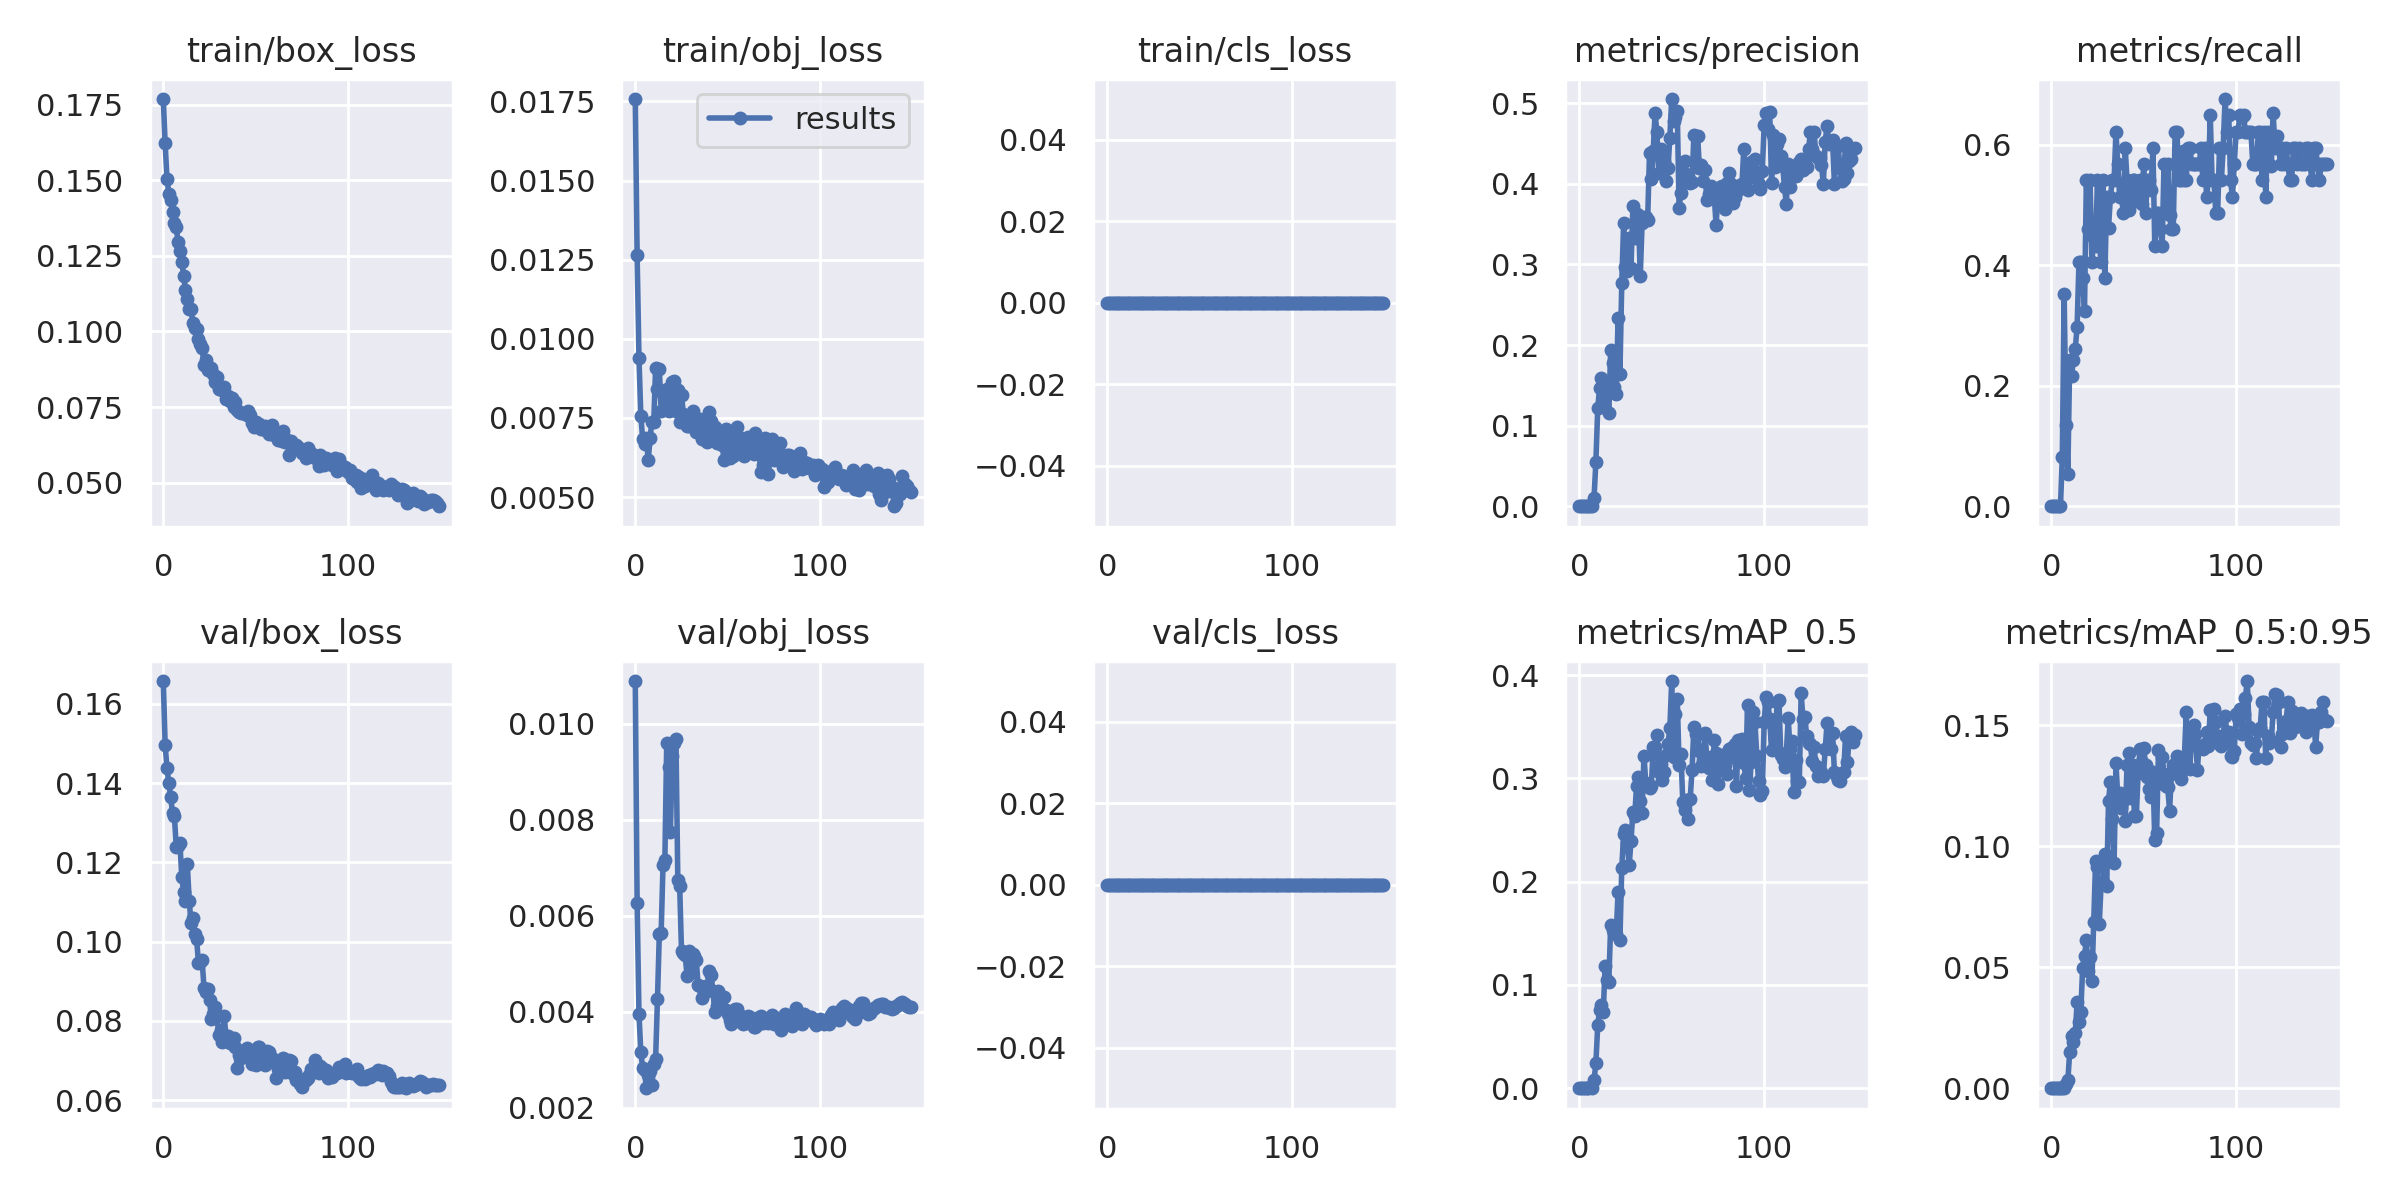

In [9]:
display.Image(f"runs_raquette/feature_extraction/results.png")

# **Fine Tuning**

In [14]:
!python train.py --hyp 'runs_raquette/feature_extraction/hyp.yaml' --batch 16 --epochs 100 --data 'data/raquette_data.yaml' --weights 'runs_raquette/feature_extraction/weights/best.pt' --project 'runs_raquette' --name 'fine-tuning' --cache


train: weights=runs_raquette/feature_extraction/weights/best.pt, cfg=, data=data/raquette_data.yaml, hyp=runs_raquette/feature_extraction/hyp.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs_raquette, name=fine-tuning, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-12-g7f5724b Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou

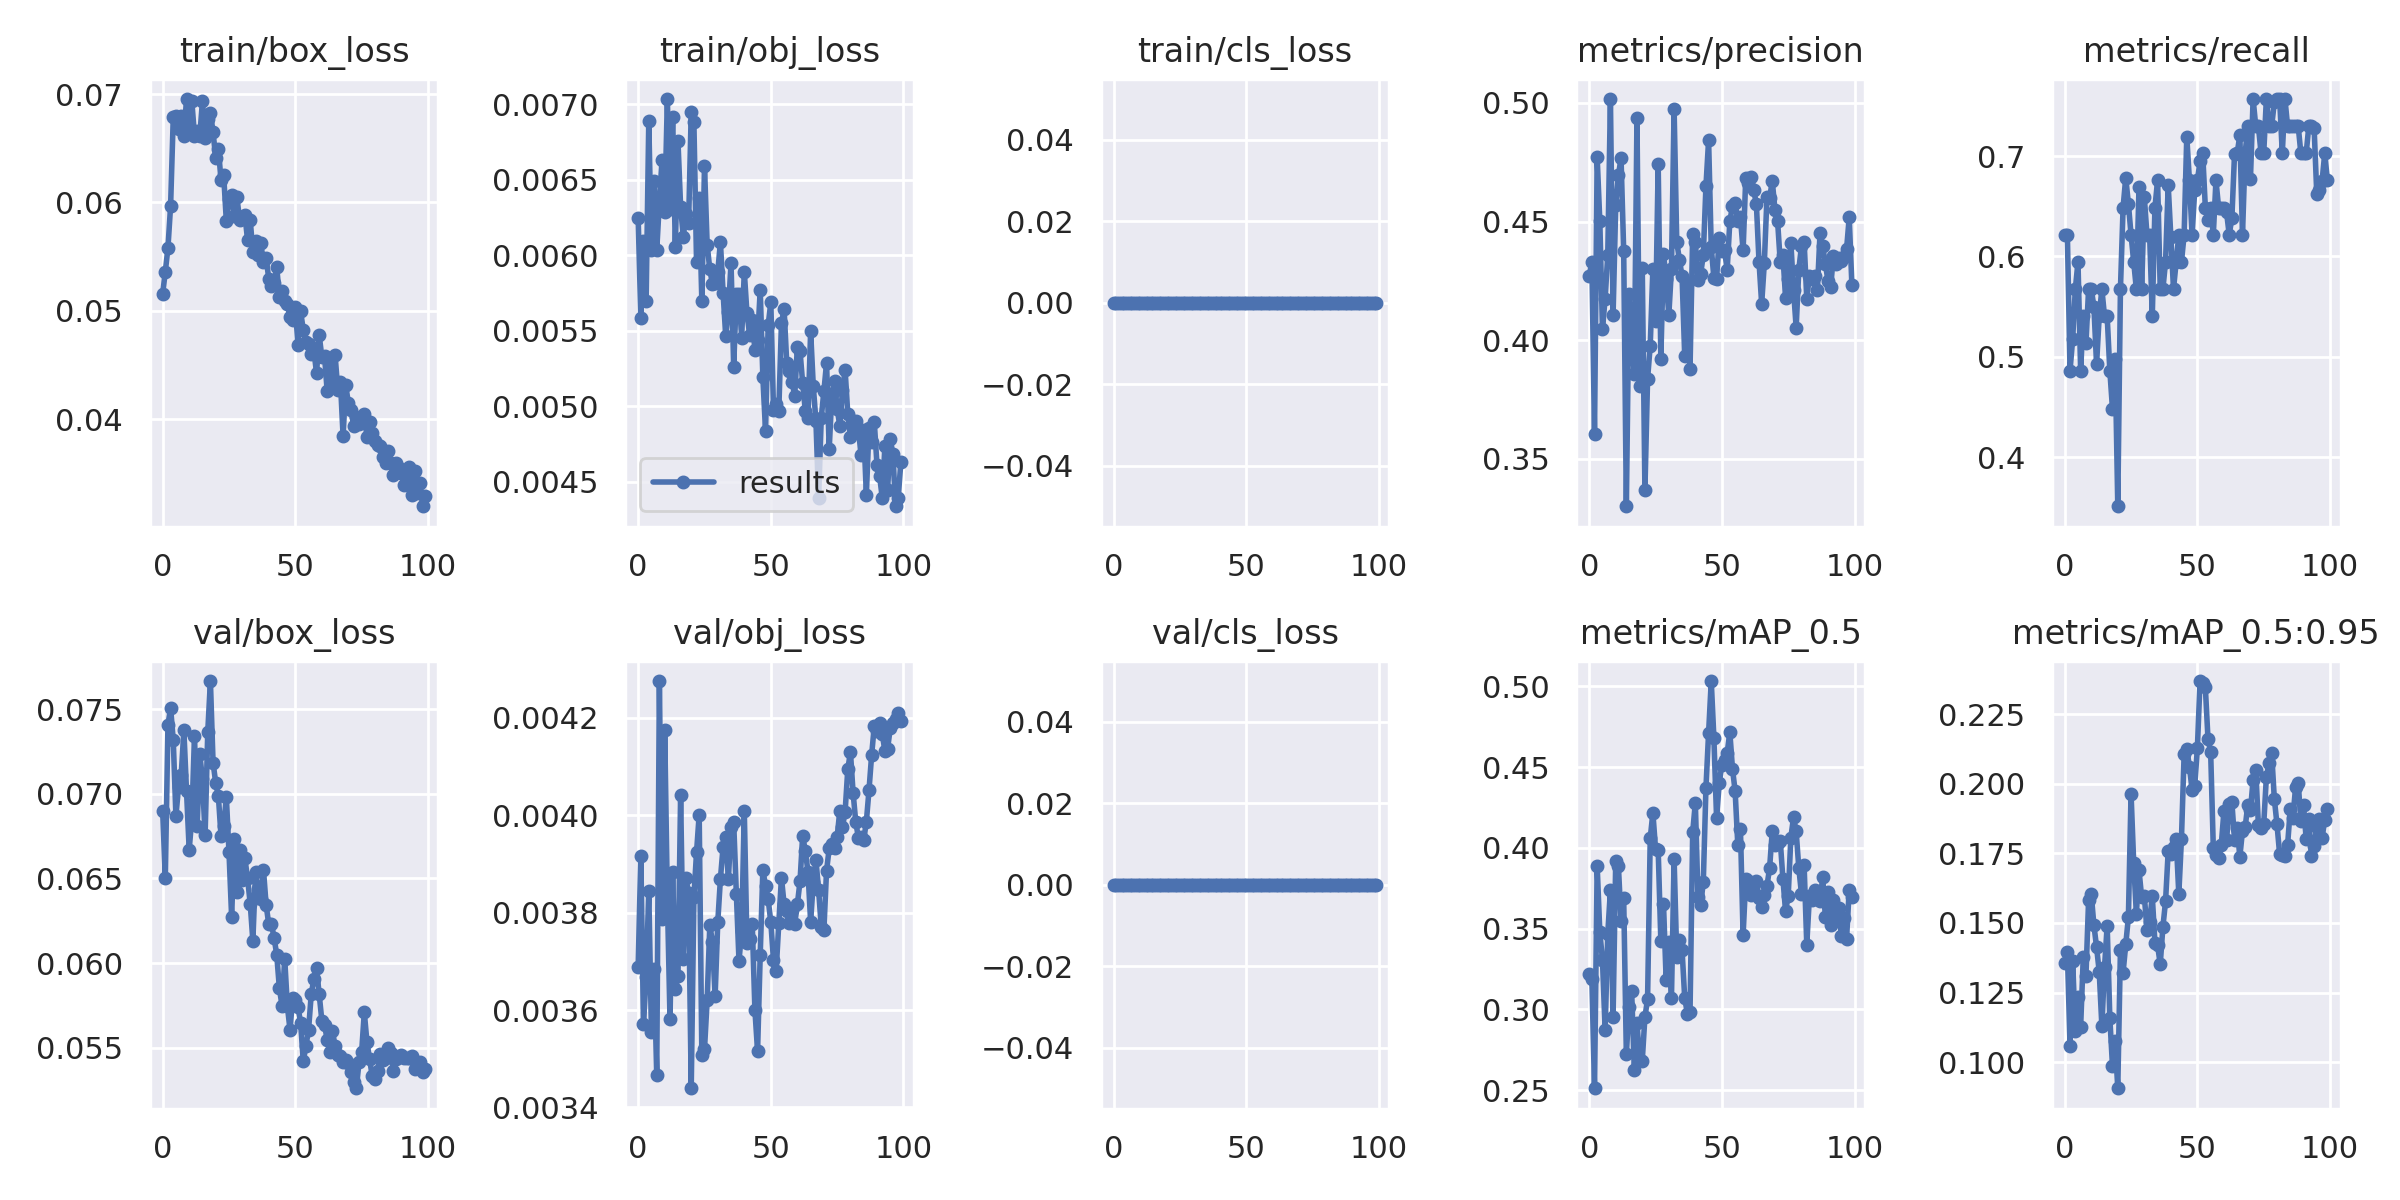

In [16]:
display.Image(f"runs_raquette/fine-tuning/results.png")

# **Validation**

In [17]:
!python val.py --weights 'runs_raquette/fine-tuning/weights/best.pt' --batch 64 --data 'data/raquette_data.yaml' --task test --project 'runs_raquette' --name 'validation_on_test_data' --augment


val: data=data/raquette_data.yaml, weights=['runs_raquette/fine-tuning/weights/best.pt'], batch_size=64, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=True, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs_raquette, name=validation_on_test_data, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-12-g7f5724b Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 206 layers, 12308200 parameters, 0 gradients, 16.1 GFLOPs
test: Scanning /content/yolov5/datasets/raquette_data/labels/test... 38 images, 8 backgrounds, 0 corrupt: 100% 46/46 [00:00<00:00, 397.72it/s]
test: New cache created: /content/yolov5/datasets/raquette_data/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:03<00:00,  3.28s/it]
                   all         46         39       0.87      0.795      

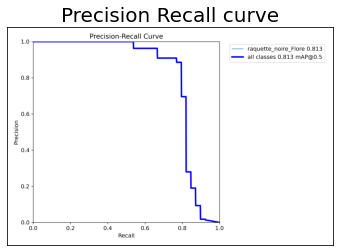

In [19]:
plt.plot(figsize=(20,20))
plt.title('Precision Recall curve', fontsize=20)
plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
plt.imshow(mpimg.imread('runs_raquette/validation_on_test_data/PR_curve.png'))

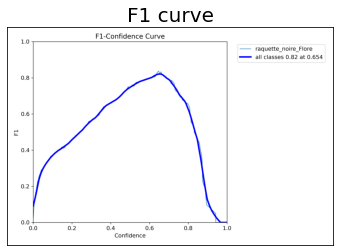

In [34]:
plt.plot(figsize=(20,20))
plt.title('F1 curve', fontsize=20)
plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
plt.imshow(mpimg.imread('runs_raquette/validation_on_test_data/F1_curve.png'))

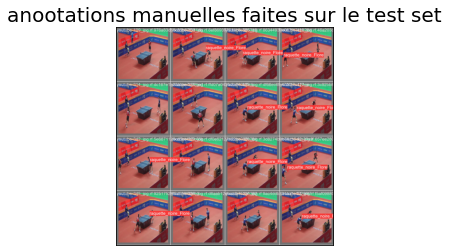

In [39]:
plt.plot(figsize=(20,20))
plt.title('anootations manuelles faites sur le test set', fontsize=20)
plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
plt.imshow(mpimg.imread('runs_raquette/validation_on_test_data/val_batch0_labels.jpg'))

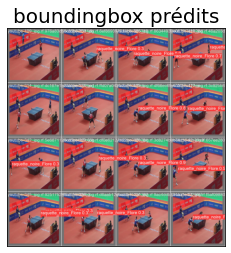

In [40]:
plt.plot(figsize=(20,20))
plt.title('boundingbox prédits', fontsize=20)
plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
plt.imshow(mpimg.imread('runs_raquette/validation_on_test_data/val_batch0_pred.jpg'))

# **Inference**

In [24]:
!python detect.py --weights 'runs_raquette/fine-tuning/weights/best.pt'  --conf 0.6 --source 'datasets/raquette_data/images/test' --project 'runs_raquette' --name 'detect_test' --augment --line=3

detect: weights=['runs_raquette/fine-tuning/weights/best.pt'], source=datasets/raquette_data/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=runs_raquette, name=detect_test, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-12-g7f5724b Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 206 layers, 12308200 parameters, 0 gradients, 16.1 GFLOPs
image 1/46 /content/yolov5/datasets/raquette_data/images/test/youtube-109_jpg.rf.976a83d55c35b02f0d1db5c39961749c.jpg: 640x640 (no detections), 41.0ms
image 2/46 /content/yolov5/datasets/raquette_data/images/test/youtube-11_jpg.rf.8683369d194c13201f0058acb1b48c3b.jpg: 640x640 1 raquette_noire_Flore, 41.1ms
imag

Le code suivant permet de montrer l'ensemble des résulats sur le test set avec le cofficient de confidence et la classe de l'objet ( ici la raquette).

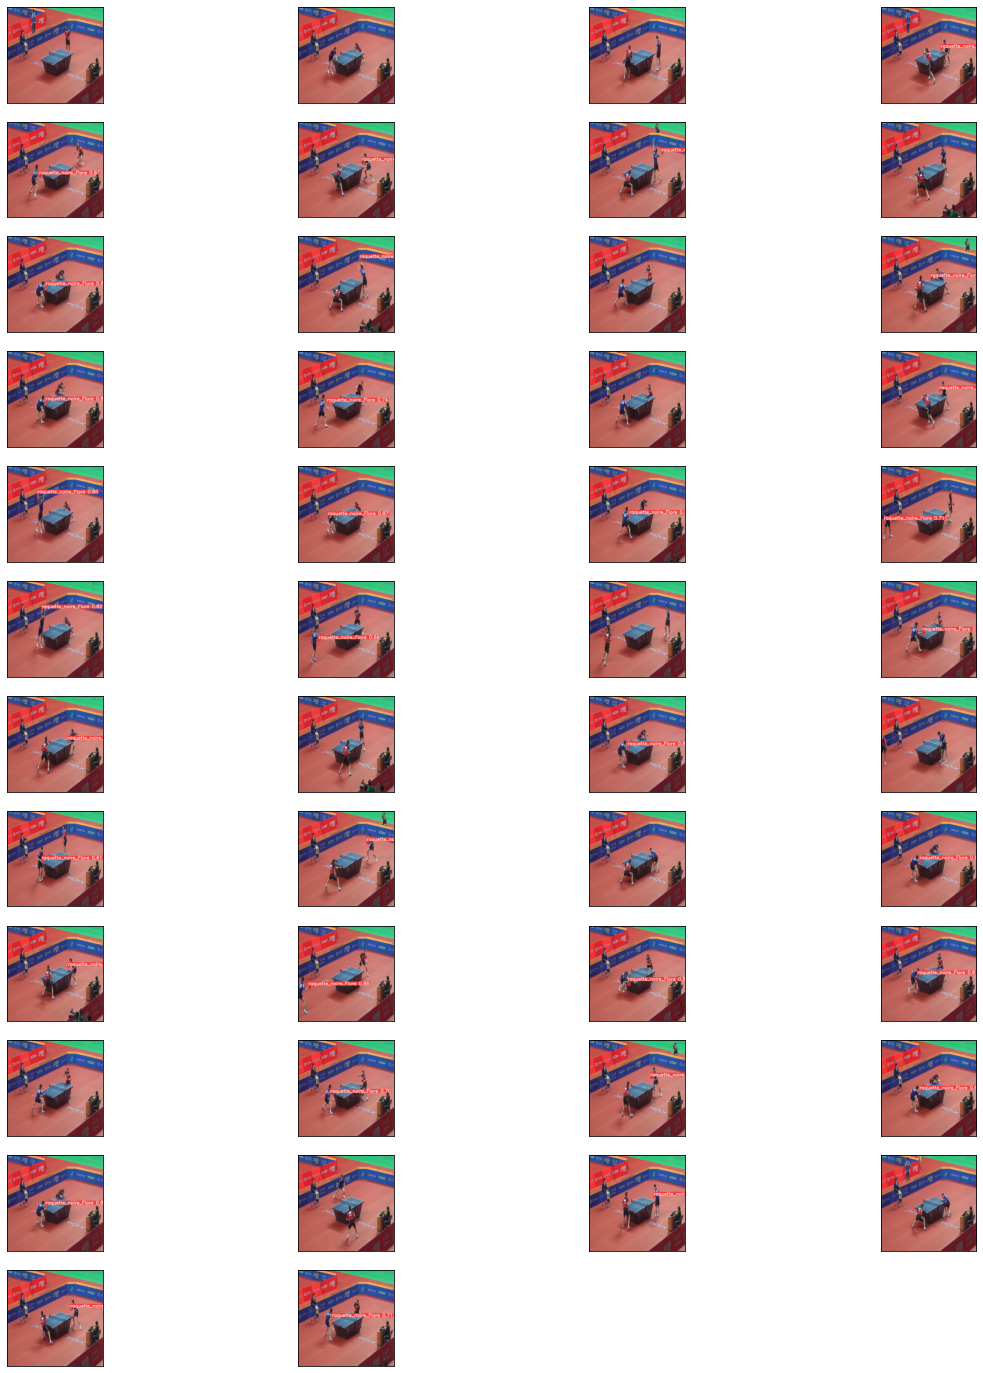

In [33]:
detect_path = r'runs_raquette/detect_test5'

images = []
for img_path in glob.glob(detect_path + '/*.jpg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,25))
columns = 4
for i, image in enumerate(images):
    plt.subplot((int(len(images) / columns + 1)), columns, i + 1)
    plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
    plt.imshow(image)